In [32]:
import numpy as np
import torch
import matplotlib.pyplot as plt

from openTSNE import TSNE

In [4]:
%cd ..

/nfs/homedirs/fuchsgru/MastersThesis


In [5]:
import configuration
import model_registry
import data.construct
import data.constants as dconst
from data.util import data_get_num_attributes, data_get_num_classes, vertex_intersection, label_binarize
from model.semi_supervised_node_classification import SemiSupervisedNodeClassification
from model.density import get_density_model
import util
from plot.density import plot_density, get_dimensionality_reduction_to_plot
from plot.util import get_greyscale_colormap, plot_histograms
import seed
import evaluation.callbacks
from evaluation.util import run_model_on_datasets
import evaluation.constants as econst
from torch_geometric.loader import DataLoader

In [6]:
ckpt_path = '/nfs/students/fuchsgru/model_registry/889940799.ckpt'

In [8]:
registry = model_registry.ModelRegistry()
# Find a cnfg for that checkpoint
for config, path in registry.items():
    if path == ckpt_path:
        break
else:
    raise RuntimeError(f'Could not find a configuration for {ckpt_path}')

In [9]:
data_dict, fixed_vertices = data.construct.load_data_from_configuration(config.data, config.registry.split_seed)

In [10]:
data_loaders = {
    name : DataLoader(data, batch_size=1, shuffle=False) for name, data in data_dict.items()
}

In [12]:
config.data.setting, config.data.ood_type, config.model.use_spectral_norm, config.model.residual

('hybrid', 'left-out-classes', False, False)

In [13]:
model = SemiSupervisedNodeClassification(
    config.model, 
    data_get_num_attributes(data_dict[dconst.TRAIN][0]), 
    data_get_num_classes(data_dict[dconst.TRAIN][0]), 
    learning_rate=config.training.learning_rate,
    weight_decay=config.training.weight_decay,
)

In [14]:
ckpt_path = registry[config]
if not ckpt_path:
    raise RuntimeError(f'No model checkpoint found!')

In [15]:
model = model.load_from_checkpoint(ckpt_path, strict=False, backbone_configuration=config.model)
_ = model.eval()
model.clear_and_disable_cache()

In [28]:
with torch.no_grad():
    out_train = model(data_dict[dconst.TRAIN][0])
    out_val = model(data_dict[dconst.VAL][0])
    out_ood = model(data_dict[dconst.OOD_VAL][0])

In [29]:
mask_train = data_dict[dconst.TRAIN][0].mask
mask_val = data_dict[dconst.VAL][0].mask
mask_ood = data_dict[dconst.OOD_VAL][0].mask

In [42]:
y_train = data_dict[dconst.TRAIN][0].y
y_val = data_dict[dconst.VAL][0].y
y_ood = data_dict[dconst.OOD_VAL][0].y

In [30]:
acc_val = ((out_val.get_logits().cpu().argmax(1) == data_dict[dconst.VAL][0].y)[mask_val]).sum() / mask_val.sum()
print(f'Validation accuracy {acc_val.item():.3f}')

Validation accuracy 0.864


In [33]:
features_train = out_train.get_features(-2).cpu()
features_val = out_val.get_features(-2).cpu()
features_ood = out_ood.get_features(-2).cpu()

In [94]:
from plot.density import get_dimensionality_reduction_to_plot, plot_density

In [73]:
embeddings, is_train, grids, grid_inverses = get_dimensionality_reduction_to_plot(
    torch.cat((features_train[mask_train], features_val[mask_val]), 0).numpy(),
    features_ood[mask_ood].numpy(),
    ('umap', ),
)

In [77]:
grid_inverses['umap'].shape

(20, 20, 64)

In [64]:
from model.normalizing_flow import NormalizingFlow
import pyblaze.nn as xnn
from tqdm import tqdm

In [67]:
mask_train_class_0 = (y_train == 0)  & mask_train
mask_val_class_0 = (y_val == 0) & mask_val

In [56]:
mask_train_class_0.sum()

tensor(20)

In [123]:
from torch.typing import OptTensor

ModuleNotFoundError: No module named 'torch.typing'

In [126]:
nf = NormalizingFlow('maf', 2, features_train.size(1)).xflow
nf = NormalizingFlow('radial', 10, features_train.size(1)).xflow

In [127]:
sum(p.view(-1).size(0) for p in nf.parameters())

660

In [118]:
loss_fn = xnn.TransformedNormalLoss(reduction='none')
optimizer = torch.optim.Adam(nf.parameters(), lr=1e-3, weight_decay=1e-3)

In [119]:
train_losses, val_losses = [], []
best_val_loss, best_state = np.inf, None
patience = 5
no_improvements = 0

for it in tqdm(range(200)):
    nf.train()
    optimizer.zero_grad()
    loss = loss_fn(*nf(features_train[mask_train_class_0]))
    loss = loss.mean()
    loss.backward()
    optimizer.step()
    train_losses.append(loss.item())
    with torch.no_grad():
        nf.eval()
        loss_val = loss_fn(*nf(features_val[mask_val_class_0])).mean()
        val_losses.append(loss_val.item())
    
    if loss_val < best_val_loss:
        no_improvements = 0
        best_val_loss = loss_val
        best_state = nf.state_dict()
    else:
        no_improvements += 1
        if no_improvements >= patience:
            # nf.load_state_dict(best_state)
            print(f'No improvement for {patience} iterations. Stopping.')
            break
    
    
    

  3%|▎         | 6/200 [00:00<00:11, 17.48it/s]

No improvement for 5 iterations. Stopping.


In [120]:
print(val_losses)

[-9.479090690612793, -47.16130065917969, -29.278675079345703, -14.287191390991211, -11.699040412902832, -11.221278190612793, -10.982568740844727]


In [121]:
with torch.no_grad():
    nf.eval()
    log_density_grid = -xnn.TransformedNormalLoss(reduction='none')(*nf(
        torch.Tensor(grid_inverses['umap']).view((-1, features_train.size(1)))
    )).view((20, 20))

(<Figure size 720x288 with 3 Axes>,
 array([[<AxesSubplot:>, <AxesSubplot:>]], dtype=object))

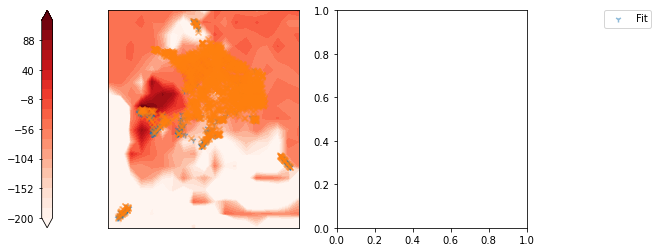

In [122]:
plot_density(embeddings['umap'][is_train], embeddings['umap'][~is_train], grids['umap'], 
             log_density_grid.numpy(), np.zeros(int((~is_train).sum())), {0 : ''}, vmax=120, vmin=-200 )